In [1]:
# Importing essential libraries for numerical operations, data handling, and file manipulation
import numpy as np  # For numerical operations
import pandas as pd  # For working with structured data (dataframes)
import os  # For interacting with the operating system (like file paths)

# TensorFlow and Keras for building and training deep learning models
import tensorflow as tf
from tqdm import tqdm  # For displaying progress bars during loops

# Keras utilities for image and text preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array  # For image augmentation/loading
from tensorflow.keras.preprocessing.text import Tokenizer  # For tokenizing captions/text
from tensorflow.keras.preprocessing.sequence import pad_sequences  # For padding sequences to the same length
from tensorflow.keras.utils import Sequence, to_categorical  # Sequence for data generators, one-hot encoding with to_categorical

# Importing Keras model-related classes
from tensorflow.keras.models import Sequential, Model  # For building models
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, GlobalAveragePooling2D,  # CNN layers for feature extraction
    Activation, Dropout, Flatten, Dense,           # Basic NN layers
    Input, Layer,                                  # Input layer and base Layer class
    Embedding, LSTM, add, Concatenate, Reshape,    # Layers for image captioning models (especially for text generation)
    concatenate, Bidirectional                     # For merging layers and bidirectional LSTM
)

# Pre-trained CNN architectures for feature extraction from images
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201

# Optimizer and callbacks to improve training process
from tensorflow.keras.optimizers import Adam  # Optimizer
from tensorflow.keras.callbacks import (
    ModelCheckpoint,  # To save best model
    EarlyStopping,    # To stop training early if no improvement
    ReduceLROnPlateau # To reduce learning rate if validation loss stagnates
)

# Suppress warning messages
import warnings
warnings.filterwarnings('ignore')

# Libraries for visualization
import matplotlib.pyplot as plt  # For plotting graphs and images
import seaborn as sns  # For stylish and advanced plotting
from textwrap import wrap  # To wrap long text for display in plots

# Configure plot font size and style
plt.rcParams['font.size'] = 12  # Set default font size for plots
sns.set_style("dark")  # Set Seaborn style for plots


In [2]:
# Set the path to the folder containing the images used for training/testing
image_path = "D:/VIT FILES/NLP/Images"

In [3]:
# Load the caption data from a text file (CSV format) into a pandas DataFrame
data = pd.read_csv("captions.txt")

In [4]:
# Function to read and preprocess a single image:
# Loads the image from the given path, resizes it to 224x224, converts to array, and normalizes pixel values
def readImage(path, img_size=224):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.
    return img

# Function to display 15 images and their captions from the provided DataFrame:
# It creates a 5x5 grid of images using matplotlib, shows each image with its caption as the title
def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)  # Reset index to avoid mismatch during looping
    plt.figure(figsize=(20, 20))  # Set the overall figure size
    n = 0
    for i in range(15):  # Display 15 images
        n += 1
        plt.subplot(5, 5, n)  # Plot in a 5x5 grid
        plt.subplots_adjust(hspace=0.7, wspace=0.3)  # Adjust spacing between images
        image = readImage(f"D:/VIT FILES/NLP/Images/{temp_df.image[i]}")  # Read and preprocess image
        plt.imshow(image)  # Show the image
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))  # Wrap and display the caption
        plt.axis("off")  # Hide axis ticks


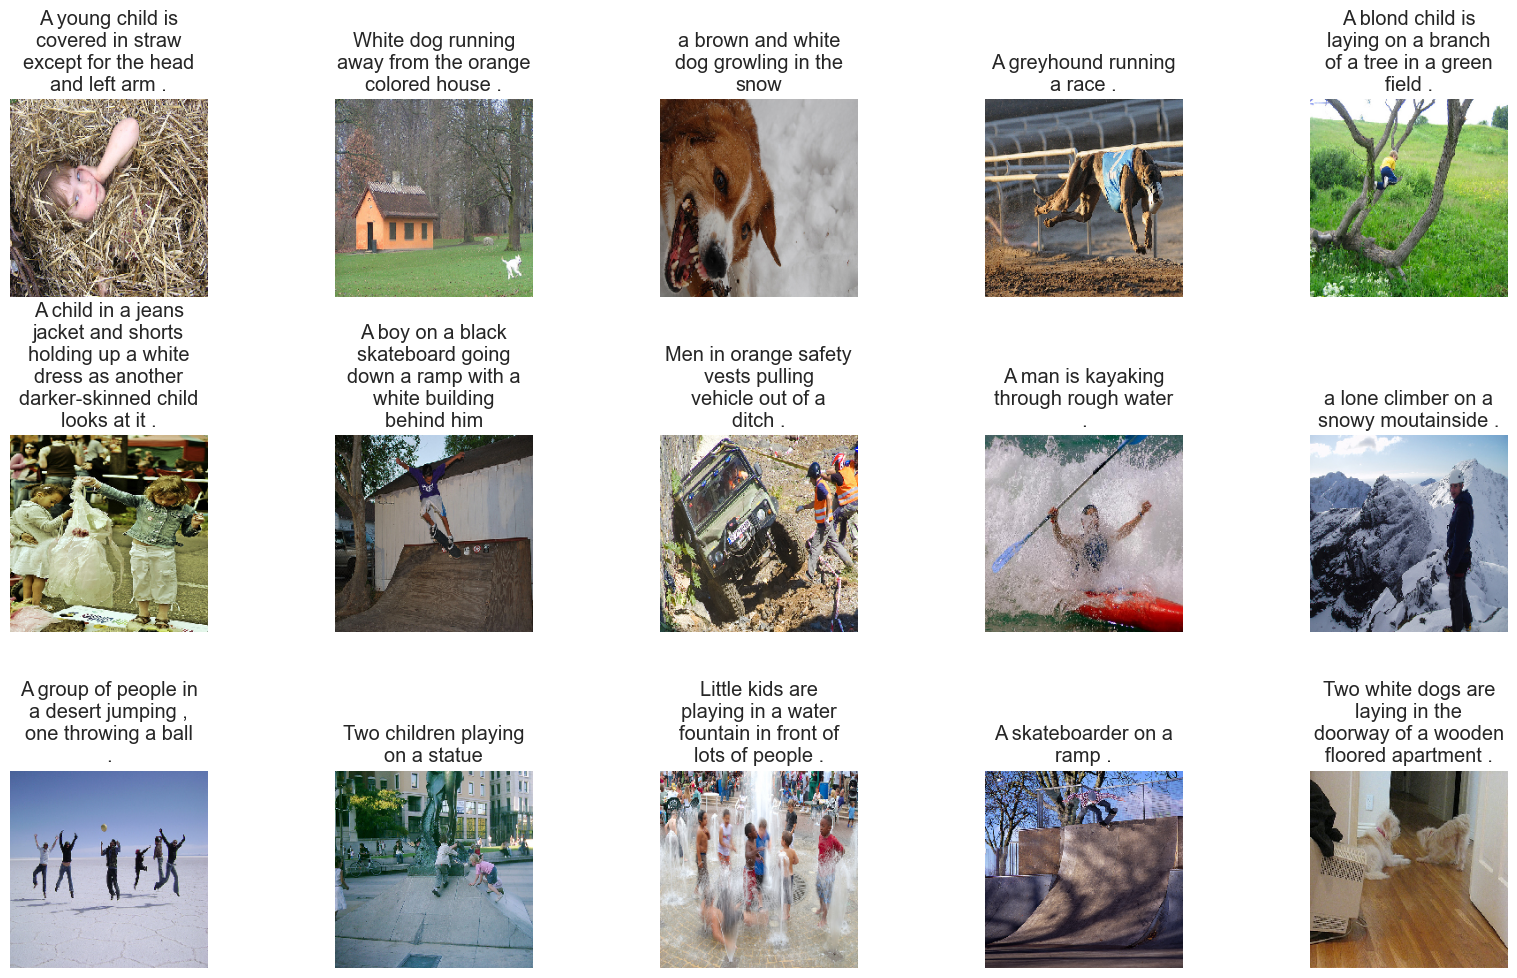

In [5]:
# Randomly selects 15 rows (image-caption pairs) from the 'data' DataFrame
# and displays them using the 'display_images' function.
# This gives a quick visual check of different images and their associated captions.
display_images(data.sample(15))


In [6]:
# This function preprocesses the image captions by cleaning the text and adding start and end tokens.
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data


In [7]:
# This code applies the text preprocessing function to clean the captions and then retrieves the first 10 processed captions.
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]


['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [8]:
# This block of code initializes the tokenizer, computes the vocabulary size, and splits the dataset into training and validation sets.
# It also converts a sample caption to a sequence of integers based on the tokenizer.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]


[1, 18, 315, 63, 195, 116, 2]

In [9]:
# This block of code uses the DenseNet201 model as a feature extractor by removing the last layer.
# It processes each image in the dataset, extracts features from the penultimate layer, and stores these features in a dictionary.
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature


100%|██████████████████████████████████████████████████████████████████████████████| 8091/8091 [34:52<00:00,  3.87it/s]


In [10]:
# CustomDataGenerator class is used to generate batches of data for training a model.
# It inherits from Keras's Sequence class, which ensures that the data is yielded in a thread-safe manner for use in model training.

class CustomDataGenerator(Sequence):
    
    # Initialize the data generator with necessary parameters
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features, shuffle=True):
        self.df = df.copy()  # Dataframe containing image-caption pairs
        self.X_col = X_col  # Column name for images
        self.y_col = y_col  # Column name for captions
        self.directory = directory  # Path where images are stored
        self.batch_size = batch_size  # Batch size for training
        self.tokenizer = tokenizer  # Tokenizer used to process captions
        self.vocab_size = vocab_size  # Vocabulary size (number of unique words in captions)
        self.max_length = max_length  # Maximum length of captions
        self.features = features  # Pre-extracted image features
        self.shuffle = shuffle  # Flag indicating if the data should be shuffled after each epoch
        self.n = len(self.df)  # Total number of samples in the dataframe
        
    # Shuffles the data at the end of each epoch, if shuffle is set to True
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    # Returns the number of batches per epoch
    def __len__(self):
        return self.n // self.batch_size
    
    # Fetch a batch of data
    def __getitem__(self,index):
        # Select the batch of data based on the index
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        # Get the input data and corresponding labels
        X1, X2, y = self.__get_data(batch)        
        # Return the batch of data (X1 = image features, X2 = caption sequences, y = one-hot encoded target words)
        return (X1, X2), y
    
    # Prepares the data (image features, caption sequences, and target words)
    def __get_data(self,batch):
        # Lists to store data
        X1, X2, y = list(), list(), list()
        
        # Get the list of images in the current batch
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]  # Extract the feature vector of the current image
            
            # Get the list of captions for the current image
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]  # Convert the caption into a sequence of integers

                # Generate input-output pairs for training the captioning model
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]  # Split the sequence into input (in_seq) and target (out_seq)
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]  # Pad the input sequence to the maximum length
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]  # One-hot encode the target word
                    X1.append(feature)  # Add image feature to input X1
                    X2.append(in_seq)   # Add input sequence to X2
                    y.append(out_seq)   # Add one-hot encoded target word to y
            
        # Convert the lists to numpy arrays for better performance during model training
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y  # Return image features, input sequences, and target words


# Create the training data generator using the CustomDataGenerator class
train_generator = CustomDataGenerator(df=train, X_col='image', y_col='caption', batch_size=64, directory=image_path,
                                      tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=features)

# Create the validation data generator using the CustomDataGenerator class
validation_generator = CustomDataGenerator(df=test, X_col='image', y_col='caption', batch_size=64, directory=image_path,
                                           tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=features)


In [11]:
# Import necessary Keras utilities and callbacks for model architecture and training
from tensorflow.keras.utils import plot_model

# Define the input layers for the image features and captions
input1 = Input(shape=(1920,))  # Image features as input
input2 = Input(shape=(max_length,))  # Sequence of word indices as input (captions)

# Process the image features using a dense layer and reshape them
img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)  # Reshape for merging

# Process the caption sequence using an embedding layer
sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)

# Merge image features and caption features
merged = concatenate([img_features_reshaped, sentence_features], axis=1)

# Apply an LSTM to process the merged features (image + caption)
sentence_features = LSTM(256)(merged)

# Apply dropout for regularization
x = Dropout(0.5)(sentence_features)

# Add the original image features to the output
x = add([x, img_features])

# Further processing through dense layers for prediction
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization
output = Dense(vocab_size, activation='softmax')(x)  # Softmax for output probabilities

# Create and compile the model
caption_model = Model(inputs=[input1, input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

# Import callbacks for model training
from tensorflow.keras.callbacks import ModelCheckpoint

# Define a model checkpoint to save the best model based on validation loss
model_name = "model.keras"  # File to save the best model
checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",  # Monitor validation loss
    mode="min",  # Save the model with the minimum validation loss
    save_best_only=True,  # Only save the best model
    save_weights_only=False,  # Save the entire model
    verbose=1
)

# Define early stopping to stop training if validation loss does not improve
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)

# Define learning rate reduction to decrease the learning rate when validation loss plateaus
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

# Train the model with the defined generators and callbacks
history = caption_model.fit(
        train_generator,  # Training data
        epochs=50,  # Number of training epochs
        validation_data=validation_generator,  # Validation data
        callbacks=[checkpoint, earlystopping, learning_rate_reduction]  # Callbacks to monitor training
)


Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - loss: 5.7058
Epoch 1: val_loss improved from inf to 4.29644, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 413s 763ms/step - loss: 5.7046 - val_loss: 4.2964 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/step - loss: 4.3388
Epoch 2: val_loss improved from 4.29644 to 3.96440, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 478s 890ms/step - loss: 4.3387 - val_loss: 3.9644 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - loss: 4.0230
Epoch 3: val_loss improved from 3.96440 to 3.81095, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 381s 708ms/step - loss: 4.0229 - val_loss: 3.8109 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - loss: 3.8345
Epoch 4: val_loss improved from 3.81095 to 3.73215, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 376s 701ms/step - loss: 3.8345 - val_loss: 3.7321 - learning_rate: 0.0

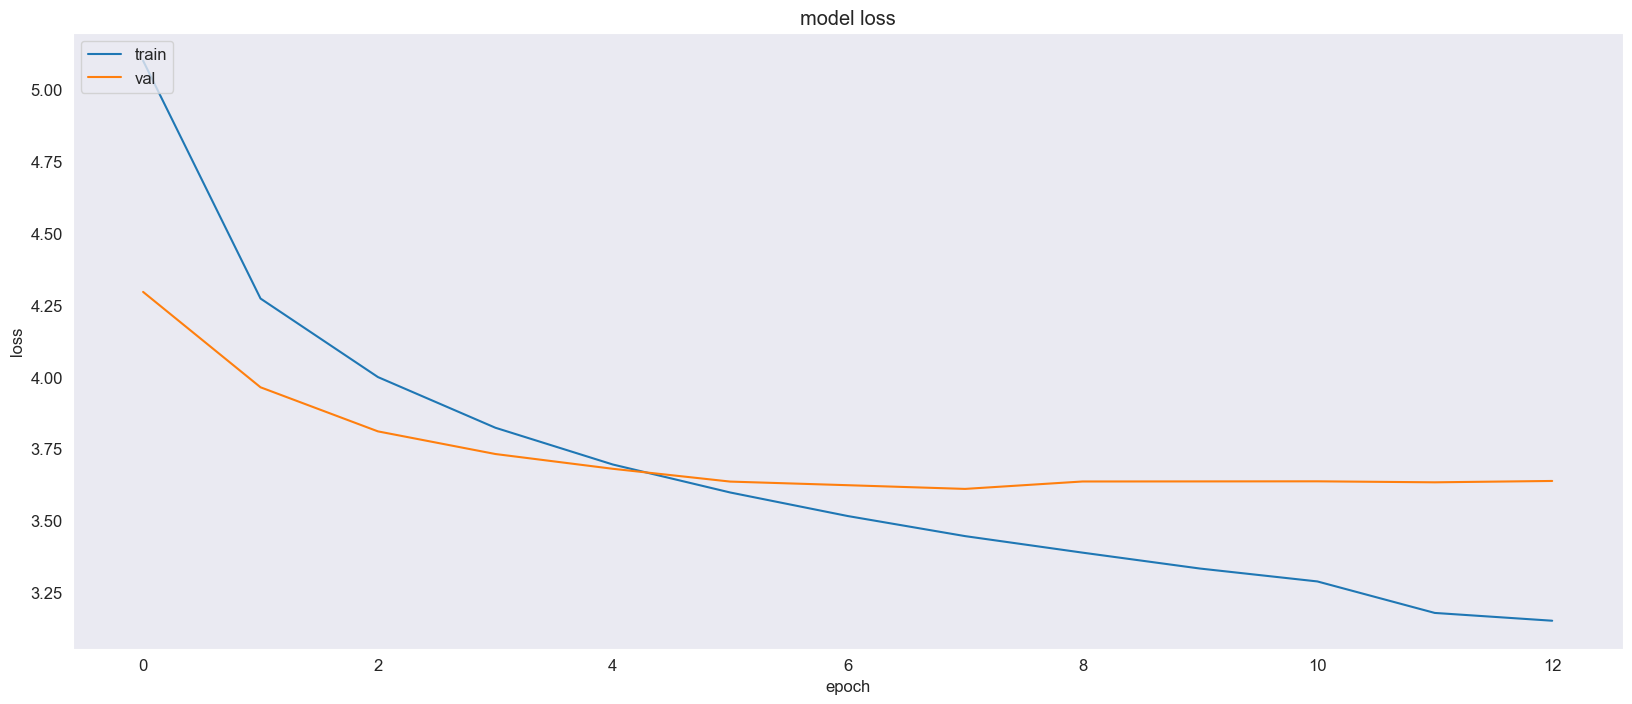

In [12]:
# Plot the training and validation loss curves to visualize model performance across epochs
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])  # Plot training loss
plt.plot(history.history['val_loss'])  # Plot validation loss
plt.title('model loss')  # Title for the plot
plt.ylabel('loss')  # Label for the y-axis
plt.xlabel('epoch')  # Label for the x-axis
plt.legend(['train', 'val'], loc='upper left')  # Add a legend to differentiate between training and validation losses
plt.show()  # Display the plot


In [13]:
import pickle

# Save the tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save the feature extractor model
fe.save("feature_extractor.keras")


In [14]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pickle
from textwrap import wrap

# Function to generate a caption for a given image and display it
def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=34, img_size=224):
    try:
        # Load the pre-trained caption model, feature extractor, and tokenizer
        caption_model = load_model(model_path)
        feature_extractor = load_model(feature_extractor_path)
        with open(tokenizer_path, "rb") as f:
            tokenizer = pickle.load(f)
    except Exception as e:
        print("Error loading model or tokenizer:", e)
        return

    try:
        # Preprocess the image to make it compatible with the model
        img = load_img(image_path, target_size=(img_size, img_size))
        img = img_to_array(img) / 255.0
        img = np.expand_dims(img, axis=0)
        image_features = feature_extractor.predict(img, verbose=0)
    except Exception as e:
        print("Error processing image:", e)
        return

    # Generate caption based on the image features and the trained model
    in_text = "startseq"
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break

    caption = in_text.replace("startseq", "").replace("endseq", "").strip()

    # Display the image and its generated caption
    img_display = load_img(image_path, target_size=(img_size, img_size))
    plt.figure(figsize=(8, 8))
    plt.imshow(img_display)
    plt.axis('off')
    plt.title("\n".join(wrap(caption, width=30)), fontsize=16, color='blue')
    plt.show()


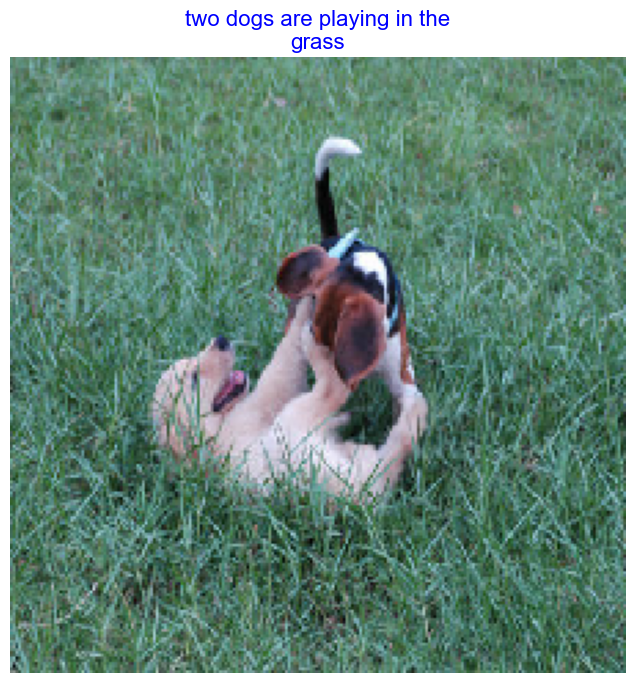

In [16]:
# Define the paths to your saved model and tokenizer files
model_path = "model.keras"
feature_extractor_path = "feature_extractor.keras"
tokenizer_path = "tokenizer.pkl"

# Example image path
image_path = "D:/VIT FILES/NLP/Images/23445819_3a458716c1.jpg"

# Call the function
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)
